In [24]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import random
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import hamming
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# готовим общий сет вакансий
df = pd.read_csv('../data/vacancies_full_keyskills.csv')
df.dropna(subset=['keySkills_str'], inplace=True)
df.head()

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
0,v_862116,Смотритель музейный,c_162972,"['Уверенный пользователь пк', 'Работа в команд...",16500.0,NaN,RUR,a_4761,ar_33,full,fullDay,noExperience,Смотритель музейный,32,4181,69972,5,5,1,Уверенный пользователь пк Работа в команде Уме...
1,v_288642,Ведущий менеджер по работе с физическими лицами,c_208672,"['Активные продажи', 'Холодные продажи', 'Кред...",50000.0,NaN,RUR,a_744,ar_2,full,fullDay,noExperience,Ведущий менеджер по работе с физическими лицами,17,6731,120750,5,5,1,Активные продажи Холодные продажи Кредитные до...
2,v_312507,Торговый представитель (г. Абакан),c_206699,"['Продуктивность', 'Клиентоориентированность',...",60000.0,NaN,RUR,a_6837,ar_4,full,fullDay,between1And3,Торговый представитель,39,6487,118557,5,5,2,Продуктивность Клиентоориентированность Работа...
3,v_2323706,Менеджер по качеству,c_244141,"['Контроль качества', 'Производственный контро...",88000.0,NaN,RUR,a_5920,ar_64,full,fullDay,between1And3,Менеджер по качеству,66,5469,160161,5,5,2,Контроль качества Производственный контроль На...
4,v_704266,Менеджер по продажам / Sales manager,c_192038,"['Активные продажи', 'Поиск и привлечение клие...",30000.0,100000.0,RUR,a_5398,ar_71,full,fullDay,between1And3,Менеджер по продажам,74,4888,102268,5,5,2,Активные продажи Поиск и привлечение клиентов ...


In [796]:
df.dtypes

vacancy_id                    object
name                          object
company_id                    object
keySkills                     object
compensation_from            float64
compensation_to              float64
compensation_currencyCode     object
area_id                       object
area_regionId                 object
employment                    object
workSchedule                  object
workExperience                object
clean_name                    object
area_regionId_encoder          int64
area_id_encoder                int64
company_id_encoder             int64
employment_encoder             int64
workSchedule_encoder           int64
workExperience_encoder         int64
keySkills_str                 object
dtype: object

In [797]:
df.head()

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
0,v_862116,Смотритель музейный,c_162972,"['Уверенный пользователь пк', 'Работа в команд...",16500.0,NaN,RUR,a_4761,ar_33,full,fullDay,noExperience,Смотритель музейный,32,4181,69972,5,5,1,Уверенный пользователь пк Работа в команде Уме...
1,v_288642,Ведущий менеджер по работе с физическими лицами,c_208672,"['Активные продажи', 'Холодные продажи', 'Кред...",50000.0,NaN,RUR,a_744,ar_2,full,fullDay,noExperience,Ведущий менеджер по работе с физическими лицами,17,6731,120750,5,5,1,Активные продажи Холодные продажи Кредитные до...
2,v_312507,Торговый представитель (г. Абакан),c_206699,"['Продуктивность', 'Клиентоориентированность',...",60000.0,NaN,RUR,a_6837,ar_4,full,fullDay,between1And3,Торговый представитель,39,6487,118557,5,5,2,Продуктивность Клиентоориентированность Работа...
3,v_2323706,Менеджер по качеству,c_244141,"['Контроль качества', 'Производственный контро...",88000.0,NaN,RUR,a_5920,ar_64,full,fullDay,between1And3,Менеджер по качеству,66,5469,160161,5,5,2,Контроль качества Производственный контроль На...
4,v_704266,Менеджер по продажам / Sales manager,c_192038,"['Активные продажи', 'Поиск и привлечение клие...",30000.0,100000.0,RUR,a_5398,ar_71,full,fullDay,between1And3,Менеджер по продажам,74,4888,102268,5,5,2,Активные продажи Поиск и привлечение клиентов ...


In [117]:
df['employment'].unique()

array(['full', 'part', 'probation', 'project', 'volunteer'], dtype=object)

In [118]:
df['workSchedule'].unique()

array(['fullDay', 'flyInFlyOut', 'shift', 'remote', 'flexible'],
      dtype=object)

In [4]:
# готовим трейн
train = pd.read_csv('../data/clean_train.csv')
train.drop('Unnamed: 0', axis=1, inplace=True)
train.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id
0,u_1036784,s_32474802,['v_2594840'],[2],[1698799954023],['v_2594840']
1,u_786220,s_14060785,"['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, ...","[1698800300793, 1698801424774, 1698800040360, ...","['v_1473781', 'v_1622905', 'v_1621959', 'v_228..."
2,u_456512,s_6053713,"['v_2267837', 'v_1724756', 'v_990702']","[2, 2, 2]","[1698802629157, 1698801355336, 1698802832097]","['v_2267837', 'v_1724756', 'v_990702']"
3,u_1114237,s_23351853,"['v_695101', 'v_154777']","[2, 2]","[1698812328790, 1698812277514]","['v_695101', 'v_154777']"
4,u_443372,s_20399354,"['v_1972205', 'v_2233339', 'v_2654866', 'v_807...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1698819501550, 1698828598668, 1698819685934, ...","['v_1972205', 'v_2233339', 'v_2654866', 'v_807..."


In [120]:
train['clear_vacancy_id'][0]

"['v_2594840']"

In [121]:
train['clear_vacancy_id_update'] = train['clear_vacancy_id'].apply(lambda x: ast.literal_eval(x))\
                                                    .apply(lambda x: [id.strip(" '[]") for id in x])
train.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update
0,u_1036784,s_32474802,['v_2594840'],[2],[1698799954023],['v_2594840'],[v_2594840]
1,u_786220,s_14060785,"['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, ...","[1698800300793, 1698801424774, 1698800040360, ...","['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[v_1473781, v_1622905, v_1621959, v_2289180, v..."
2,u_456512,s_6053713,"['v_2267837', 'v_1724756', 'v_990702']","[2, 2, 2]","[1698802629157, 1698801355336, 1698802832097]","['v_2267837', 'v_1724756', 'v_990702']","[v_2267837, v_1724756, v_990702]"
3,u_1114237,s_23351853,"['v_695101', 'v_154777']","[2, 2]","[1698812328790, 1698812277514]","['v_695101', 'v_154777']","[v_695101, v_154777]"
4,u_443372,s_20399354,"['v_1972205', 'v_2233339', 'v_2654866', 'v_807...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1698819501550, 1698828598668, 1698819685934, ...","['v_1972205', 'v_2233339', 'v_2654866', 'v_807...","[v_1972205, v_2233339, v_2654866, v_807974, v_..."


In [123]:
train['action_type_update'] = train['action_type'].apply(lambda x: ast.literal_eval(x))
train.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update
0,u_1036784,s_32474802,['v_2594840'],[2],[1698799954023],['v_2594840'],[v_2594840],[2]
1,u_786220,s_14060785,"['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, ...","[1698800300793, 1698801424774, 1698800040360, ...","['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[v_1473781, v_1622905, v_1621959, v_2289180, v...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, ..."
2,u_456512,s_6053713,"['v_2267837', 'v_1724756', 'v_990702']","[2, 2, 2]","[1698802629157, 1698801355336, 1698802832097]","['v_2267837', 'v_1724756', 'v_990702']","[v_2267837, v_1724756, v_990702]","[2, 2, 2]"
3,u_1114237,s_23351853,"['v_695101', 'v_154777']","[2, 2]","[1698812328790, 1698812277514]","['v_695101', 'v_154777']","[v_695101, v_154777]","[2, 2]"
4,u_443372,s_20399354,"['v_1972205', 'v_2233339', 'v_2654866', 'v_807...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1698819501550, 1698828598668, 1698819685934, ...","['v_1972205', 'v_2233339', 'v_2654866', 'v_807...","[v_1972205, v_2233339, v_2654866, v_807974, v_...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"


In [124]:
train['action_type_update'].explode().unique()
# 1 - отклик, 2 - просмотр (открытие страницы вакансии), 3 - добавление вакансии в избранное

array([2, 1, 3], dtype=object)

In [125]:
train['vacancy_id_like_response'] = [
    [vacancy_id for vacancy_id, action_type in zip(vacancy_ids, action_types) if action_type in [1, 3]]
    for vacancy_ids, action_types in zip(train['clear_vacancy_id_update'], train['action_type_update'])
]

In [126]:
train.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update,vacancy_id_like_response
0,u_1036784,s_32474802,['v_2594840'],[2],[1698799954023],['v_2594840'],[v_2594840],[2],[]
1,u_786220,s_14060785,"['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, ...","[1698800300793, 1698801424774, 1698800040360, ...","['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[v_1473781, v_1622905, v_1621959, v_2289180, v...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, ...","[v_1473781, v_1473781, v_2289180, v_2654062, v..."
2,u_456512,s_6053713,"['v_2267837', 'v_1724756', 'v_990702']","[2, 2, 2]","[1698802629157, 1698801355336, 1698802832097]","['v_2267837', 'v_1724756', 'v_990702']","[v_2267837, v_1724756, v_990702]","[2, 2, 2]",[]
3,u_1114237,s_23351853,"['v_695101', 'v_154777']","[2, 2]","[1698812328790, 1698812277514]","['v_695101', 'v_154777']","[v_695101, v_154777]","[2, 2]",[]
4,u_443372,s_20399354,"['v_1972205', 'v_2233339', 'v_2654866', 'v_807...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1698819501550, 1698828598668, 1698819685934, ...","['v_1972205', 'v_2233339', 'v_2654866', 'v_807...","[v_1972205, v_2233339, v_2654866, v_807974, v_...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",[]


In [127]:
train.iloc[0]

user_id                           u_1036784
session_id                       s_32474802
vacancy_id                    ['v_2594840']
action_type                             [2]
action_dt                   [1698799954023]
clear_vacancy_id              ['v_2594840']
clear_vacancy_id_update         [v_2594840]
action_type_update                      [2]
vacancy_id_like_response                 []
Name: 0, dtype: object

In [128]:
len(train['user_id'].unique())

637192

In [131]:
# готовим тест
test = pd.read_csv('../data/clean_test.csv')
test.drop('Unnamed: 0', axis=1, inplace=True)
test.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id
0,u_482520,s_25018731,"['v_2597196', 'v_1223061', 'v_1223061']","[2, 2, 1]","[1700395393089, 1700395410396, 1700395503473]","['v_2597196', 'v_1223061', 'v_1223061']"
1,u_212584,s_16918781,"['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]","[1700124107031, 1700124321403, 1700124426230, ...","['v_1572055', 'v_1572055', 'v_1572055', 'v_953..."
2,u_425177,s_17505104,"['v_1375331', 'v_1922852']","[2, 2]","[1700224938513, 1700225032744]","['v_1375331', 'v_1922852']"
3,u_700997,s_15528830,"['v_2152997', 'v_2152997', 'v_1217630']","[2, 1, 2]","[1700155373530, 1700155399885, 1700155413472]","['v_2152997', 'v_2152997', 'v_1217630']"
4,u_186164,s_34273595,"['v_2674644', 'v_2558182']","[2, 2]","[1700483122760, 1700483363810]","['v_2674644', 'v_2558182']"


In [132]:
test['clear_vacancy_id_update'] = test['clear_vacancy_id'].apply(lambda x: ast.literal_eval(x))\
                                                    .apply(lambda x: [id.strip(" '[]") for id in x])
test.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update
0,u_482520,s_25018731,"['v_2597196', 'v_1223061', 'v_1223061']","[2, 2, 1]","[1700395393089, 1700395410396, 1700395503473]","['v_2597196', 'v_1223061', 'v_1223061']","[v_2597196, v_1223061, v_1223061]"
1,u_212584,s_16918781,"['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]","[1700124107031, 1700124321403, 1700124426230, ...","['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[v_1572055, v_1572055, v_1572055, v_953153, v_..."
2,u_425177,s_17505104,"['v_1375331', 'v_1922852']","[2, 2]","[1700224938513, 1700225032744]","['v_1375331', 'v_1922852']","[v_1375331, v_1922852]"
3,u_700997,s_15528830,"['v_2152997', 'v_2152997', 'v_1217630']","[2, 1, 2]","[1700155373530, 1700155399885, 1700155413472]","['v_2152997', 'v_2152997', 'v_1217630']","[v_2152997, v_2152997, v_1217630]"
4,u_186164,s_34273595,"['v_2674644', 'v_2558182']","[2, 2]","[1700483122760, 1700483363810]","['v_2674644', 'v_2558182']","[v_2674644, v_2558182]"


In [133]:
test['action_type_update'] = test['action_type'].apply(lambda x: ast.literal_eval(x))
test.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update
0,u_482520,s_25018731,"['v_2597196', 'v_1223061', 'v_1223061']","[2, 2, 1]","[1700395393089, 1700395410396, 1700395503473]","['v_2597196', 'v_1223061', 'v_1223061']","[v_2597196, v_1223061, v_1223061]","[2, 2, 1]"
1,u_212584,s_16918781,"['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]","[1700124107031, 1700124321403, 1700124426230, ...","['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[v_1572055, v_1572055, v_1572055, v_953153, v_...","[2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]"
2,u_425177,s_17505104,"['v_1375331', 'v_1922852']","[2, 2]","[1700224938513, 1700225032744]","['v_1375331', 'v_1922852']","[v_1375331, v_1922852]","[2, 2]"
3,u_700997,s_15528830,"['v_2152997', 'v_2152997', 'v_1217630']","[2, 1, 2]","[1700155373530, 1700155399885, 1700155413472]","['v_2152997', 'v_2152997', 'v_1217630']","[v_2152997, v_2152997, v_1217630]","[2, 1, 2]"
4,u_186164,s_34273595,"['v_2674644', 'v_2558182']","[2, 2]","[1700483122760, 1700483363810]","['v_2674644', 'v_2558182']","[v_2674644, v_2558182]","[2, 2]"


In [134]:
test['vacancy_id_like_response'] = [
    [vacancy_id for vacancy_id, action_type in zip(vacancy_ids, action_types) if action_type in [1, 3]]
    for vacancy_ids, action_types in zip(test['clear_vacancy_id_update'], test['action_type_update'])
]

In [135]:
def remove_duplicates(lst):
    return list(set(lst))

test['vacancy_id_like_response'] = test['vacancy_id_like_response'].apply(remove_duplicates)

In [136]:
test.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update,vacancy_id_like_response
0,u_482520,s_25018731,"['v_2597196', 'v_1223061', 'v_1223061']","[2, 2, 1]","[1700395393089, 1700395410396, 1700395503473]","['v_2597196', 'v_1223061', 'v_1223061']","[v_2597196, v_1223061, v_1223061]","[2, 2, 1]",[v_1223061]
1,u_212584,s_16918781,"['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]","[1700124107031, 1700124321403, 1700124426230, ...","['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[v_1572055, v_1572055, v_1572055, v_953153, v_...","[2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]","[v_953153, v_1033603, v_1572055, v_1329494, v_..."
2,u_425177,s_17505104,"['v_1375331', 'v_1922852']","[2, 2]","[1700224938513, 1700225032744]","['v_1375331', 'v_1922852']","[v_1375331, v_1922852]","[2, 2]",[]
3,u_700997,s_15528830,"['v_2152997', 'v_2152997', 'v_1217630']","[2, 1, 2]","[1700155373530, 1700155399885, 1700155413472]","['v_2152997', 'v_2152997', 'v_1217630']","[v_2152997, v_2152997, v_1217630]","[2, 1, 2]",[v_2152997]
4,u_186164,s_34273595,"['v_2674644', 'v_2558182']","[2, 2]","[1700483122760, 1700483363810]","['v_2674644', 'v_2558182']","[v_2674644, v_2558182]","[2, 2]",[]


### Predict using key_skills; name

In [137]:
# хочу сравнить значимость keyskills и name на подвыборке с фиксированными другими параметрами

In [138]:
train_like_response = train[train['vacancy_id_like_response'].apply(lambda x: len(x) > 0)]
train_like_response.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update,vacancy_id_like_response
1,u_786220,s_14060785,"['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, ...","[1698800300793, 1698801424774, 1698800040360, ...","['v_1473781', 'v_1622905', 'v_1621959', 'v_228...","[v_1473781, v_1622905, v_1621959, v_2289180, v...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, ...","[v_1473781, v_1473781, v_2289180, v_2654062, v..."
5,u_494683,s_24928785,"['v_1706875', 'v_1621815', 'v_672524', 'v_1558...","[1, 2, 2, 2, 2, 1]","[1698827251583, 1698826609257, 1698826779876, ...","['v_1706875', 'v_1621815', 'v_672524', 'v_1558...","[v_1706875, v_1621815, v_672524, v_1558720, v_...","[1, 2, 2, 2, 2, 1]","[v_1706875, v_1621815]"
7,u_195766,s_26461730,"['v_1768748', 'v_1768748', 'v_915317']","[1, 2, 2]","[1698828075237, 1698827828686, 1698827849085]","['v_1768748', 'v_1768748', 'v_915317']","[v_1768748, v_1768748, v_915317]","[1, 2, 2]",[v_1768748]
8,u_328119,s_25905612,"['v_755644', 'v_2293367', 'v_755644', 'v_19038...","[2, 1, 1, 1, 1, 1, 1, 1]","[1698828640253, 1698828816410, 1698828650181, ...","['v_755644', 'v_2293367', 'v_755644', 'v_19038...","[v_755644, v_2293367, v_755644, v_1903818, v_7...","[2, 1, 1, 1, 1, 1, 1, 1]","[v_2293367, v_755644, v_1903818, v_779473, v_5..."
10,u_1047429,s_601834,['v_1126902'],[1],[1698829459454],['v_1126902'],[v_1126902],[1],[v_1126902]


In [178]:
sub_test = test[test['vacancy_id_like_response'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
sub_test.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update,vacancy_id_like_response
0,u_482520,s_25018731,"['v_2597196', 'v_1223061', 'v_1223061']","[2, 2, 1]","[1700395393089, 1700395410396, 1700395503473]","['v_2597196', 'v_1223061', 'v_1223061']","[v_2597196, v_1223061, v_1223061]","[2, 2, 1]",[v_1223061]
1,u_212584,s_16918781,"['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]","[1700124107031, 1700124321403, 1700124426230, ...","['v_1572055', 'v_1572055', 'v_1572055', 'v_953...","[v_1572055, v_1572055, v_1572055, v_953153, v_...","[2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]","[v_953153, v_1033603, v_1572055, v_1329494, v_..."
3,u_700997,s_15528830,"['v_2152997', 'v_2152997', 'v_1217630']","[2, 1, 2]","[1700155373530, 1700155399885, 1700155413472]","['v_2152997', 'v_2152997', 'v_1217630']","[v_2152997, v_2152997, v_1217630]","[2, 1, 2]",[v_2152997]
6,u_964771,s_21873886,"['v_1401407', 'v_1401407']","[2, 1]","[1700242054494, 1700242163536]","['v_1401407', 'v_1401407']","[v_1401407, v_1401407]","[2, 1]",[v_1401407]
7,u_1107006,s_14797400,"['v_1977347', 'v_1977347', 'v_2097290']","[2, 1, 2]","[1700481982587, 1700482050896, 1700482293843]","['v_1977347', 'v_1977347', 'v_2097290']","[v_1977347, v_1977347, v_2097290]","[2, 1, 2]",[v_1977347]


In [181]:
common_ids = list(set(sub_test['user_id'].unique()) & set(train_like_response['user_id'].unique()))
print(len(common_ids))

8432


In [182]:
test_indices = random.sample(common_ids, 5000)
test_indices[:2]

['u_343537', 'u_475741']

In [183]:
sub_train = train[train['user_id'].isin(test_indices)].copy()
sub_train.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update,vacancy_id_like_response
55,u_679523,s_24188480,"['v_1241375', 'v_1575561', 'v_698846']","[2, 2, 2]","[1698914355776, 1698916221530, 1698916300301]","['v_1241375', 'v_1575561', 'v_698846']","[v_1241375, v_1575561, v_698846]","[2, 2, 2]",[]
75,u_173499,s_29170599,"['v_1124854', 'v_413102', 'v_1550927', 'v_1141...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2]","[1698933939069, 1698931723447, 1698931726694, ...","['v_1124854', 'v_413102', 'v_1550927', 'v_1141...","[v_1124854, v_413102, v_1550927, v_1141407, v_...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2]","[v_1124854, v_1472872, v_125743]"
104,u_1080677,s_6366635,"['v_2083494', 'v_1541910', 'v_672371', 'v_2594...","[1, 2, 2, 2, 2, 2]","[1698953852270, 1698953321016, 1698954131746, ...","['v_2083494', 'v_1541910', 'v_672371', 'v_2594...","[v_2083494, v_1541910, v_672371, v_2594658, v_...","[1, 2, 2, 2, 2, 2]",[v_2083494]
111,u_990504,s_18235123,['v_1868824'],[2],[1698978311181],['v_1868824'],[v_1868824],[2],[]
387,u_750639,s_5185336,"['v_1983790', 'v_2405241', 'v_2290144', 'v_752...","[2, 1, 3, 2, 3, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, ...","[1699716206539, 1699715277995, 1699717163393, ...","['v_1983790', 'v_2405241', 'v_2290144', 'v_752...","[v_1983790, v_2405241, v_2290144, v_752239, v_...","[2, 1, 3, 2, 3, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, ...","[v_2405241, v_2290144, v_329010, v_329010, v_1..."


In [184]:
def remove_duplicates(lst):
    return list(set(lst))

In [185]:
sub_train['vacancy_id_like_response'] = sub_train['vacancy_id_like_response'].apply(remove_duplicates)

In [186]:
sub_train.head()

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update,vacancy_id_like_response
55,u_679523,s_24188480,"['v_1241375', 'v_1575561', 'v_698846']","[2, 2, 2]","[1698914355776, 1698916221530, 1698916300301]","['v_1241375', 'v_1575561', 'v_698846']","[v_1241375, v_1575561, v_698846]","[2, 2, 2]",[]
75,u_173499,s_29170599,"['v_1124854', 'v_413102', 'v_1550927', 'v_1141...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2]","[1698933939069, 1698931723447, 1698931726694, ...","['v_1124854', 'v_413102', 'v_1550927', 'v_1141...","[v_1124854, v_413102, v_1550927, v_1141407, v_...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2]","[v_1472872, v_125743, v_1124854]"
104,u_1080677,s_6366635,"['v_2083494', 'v_1541910', 'v_672371', 'v_2594...","[1, 2, 2, 2, 2, 2]","[1698953852270, 1698953321016, 1698954131746, ...","['v_2083494', 'v_1541910', 'v_672371', 'v_2594...","[v_2083494, v_1541910, v_672371, v_2594658, v_...","[1, 2, 2, 2, 2, 2]",[v_2083494]
111,u_990504,s_18235123,['v_1868824'],[2],[1698978311181],['v_1868824'],[v_1868824],[2],[]
387,u_750639,s_5185336,"['v_1983790', 'v_2405241', 'v_2290144', 'v_752...","[2, 1, 3, 2, 3, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, ...","[1699716206539, 1699715277995, 1699717163393, ...","['v_1983790', 'v_2405241', 'v_2290144', 'v_752...","[v_1983790, v_2405241, v_2290144, v_752239, v_...","[2, 1, 3, 2, 3, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, ...","[v_1012704, v_715746, v_285872, v_752239, v_24..."


In [187]:
df['area_regionId'].value_counts()

ar_41    396017
ar_78    175900
ar_64    149555
ar_21     89833
ar_44     87498
          ...  
ar_46        27
ar_35        25
ar_30        19
ar_14        14
ar_43         1
Name: area_regionId, Length: 95, dtype: int64

In [188]:
sub_df = df[df['area_regionId'] == 'ar_41']
sub_df.head()

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
6,v_2485961,Домработница/Домработник,c_133807,"['Уборка', 'Стирка', 'Домработница']",65000.0,75000.0,RUR,a_1756,ar_41,full,fullDay,moreThan6,Домработница,41,842,37567,5,5,4,Уборка Стирка Домработница
11,v_1670705,"Личный водитель (м. Баррикадная, м. Смоленская)",c_236194,"['Водительское удостоверение категории b', 'Гр...",60000.0,80000.0,RUR,a_1756,ar_41,full,fullDay,moreThan6,Личный водитель,41,842,151330,5,5,4,Водительское удостоверение категории b Грамотн...
14,v_1695304,DevOps инженер,c_66341,"['Python', 'Grafana', 'Настройка серверов', 'У...",120000.0,180000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,DevOps инженер,41,842,241516,5,5,2,Python Grafana Настройка серверов Уверенный по...
20,v_1284861,Менеджер по развитию В2В,c_160874,"['Грамотная речь', 'Деловая переписка', 'Навык...",42000.0,NaN,RUR,a_1756,ar_41,full,remote,between1And3,Менеджер по развитию В2В,41,842,67641,5,3,2,Грамотная речь Деловая переписка Навыки межлич...
22,v_2494877,Ассистент отдела продаж,c_94905,"['Работа в команде', 'Социальные сети', '1с: т...",30000.0,30000.0,RUR,a_1756,ar_41,full,remote,between1And3,Ассистент отдела продаж,41,842,273253,5,3,2,Работа в команде Социальные сети 1с: торговля ...


In [189]:
sub_df['workExperience'].value_counts()

between1And3    184416
noExperience    124470
between3And6     75240
moreThan6        11891
Name: workExperience, dtype: int64

In [190]:
sub_df = sub_df[sub_df['workExperience'] == 'between1And3']
sub_df.head()

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
14,v_1695304,DevOps инженер,c_66341,"['Python', 'Grafana', 'Настройка серверов', 'У...",120000.0,180000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,DevOps инженер,41,842,241516,5,5,2,Python Grafana Настройка серверов Уверенный по...
20,v_1284861,Менеджер по развитию В2В,c_160874,"['Грамотная речь', 'Деловая переписка', 'Навык...",42000.0,NaN,RUR,a_1756,ar_41,full,remote,between1And3,Менеджер по развитию В2В,41,842,67641,5,3,2,Грамотная речь Деловая переписка Навыки межлич...
22,v_2494877,Ассистент отдела продаж,c_94905,"['Работа в команде', 'Социальные сети', '1с: т...",30000.0,30000.0,RUR,a_1756,ar_41,full,remote,between1And3,Ассистент отдела продаж,41,842,273253,5,3,2,Работа в команде Социальные сети 1с: торговля ...
37,v_878026,"Менеджер по продажам (удалённо, горячие входящ...",c_258818,"['Грамотная речь', 'Грамотность', 'Навыки прод...",60000.0,120000.0,RUR,a_1756,ar_41,full,remote,between1And3,Менеджер по продажам,41,842,176467,5,3,2,Грамотная речь Грамотность Навыки продаж 1с-би...
38,v_2482718,Администратор-кассир,c_258472,"['Деловое общение', 'Кассовые операции', 'Прие...",60000.0,75000.0,RUR,a_1756,ar_41,full,shift,between1And3,Администратор-кассир,41,842,176083,5,4,2,Деловое общение Кассовые операции Прием посети...


In [191]:
sub_df['workSchedule'].value_counts()

fullDay        126014
shift           26221
remote          22589
flexible         6390
flyInFlyOut      3202
Name: workSchedule, dtype: int64

In [192]:
sub_df = sub_df[sub_df['workSchedule'] == 'fullDay']
sub_df['employment'].value_counts()

full         122967
part           2514
project         377
probation       155
volunteer         1
Name: employment, dtype: int64

In [193]:
sub_df = sub_df[sub_df['employment'] == 'full']
sub_df.head()

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
14,v_1695304,DevOps инженер,c_66341,"['Python', 'Grafana', 'Настройка серверов', 'У...",120000.0,180000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,DevOps инженер,41,842,241516,5,5,2,Python Grafana Настройка серверов Уверенный по...
73,v_1756353,Менеджер по снабжению,c_128148,"['Ms excel', 'Ms excel', 'Работа в условиях мн...",70000.0,75000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,Менеджер по снабжению,41,842,31279,5,5,2,Ms excel Ms excel Работа в условиях многозадач...
77,v_471312,Менеджер по персоналу/рекрутер (кадровик),c_162514,"['Обучение персонала', 'Деловое общение', 'Тел...",50000.0,60000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,Менеджер по персоналу,41,842,69464,5,5,2,Обучение персонала Деловое общение Телефонные ...
80,v_2294305,Специалист по управлению качеством строительства,c_117235,"['Работа с большим объемом информации', 'Делов...",NaN,110000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,Специалист по управлению качеством строительства,41,842,19154,5,5,2,Работа с большим объемом информации Деловая пе...
90,v_2464854,Специалист технической поддержки,c_107186,"['Уверенный пользователь пк', 'Техническая док...",112000.0,112000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,Специалист технической поддержки,41,842,7988,5,5,2,Уверенный пользователь пк Техническая документ...


In [ ]:
# predict for all actions -- deprecated:)
user_preds = {}

for user_id in train['user_id'].unique()[:1000]:
    user_data = train[train['user_id'] == user_id]
    user_preds[user_id] = {}
    
    for vacancy_id in user_data['clear_vacancy_id_update']:
        for vacancy_id in vacancy_id:
            if vacancy_id in df['vacancy_id'].values:
                query = vectorizer.transform(df[df['vacancy_id'] == vacancy_id]['keySkills_str'])
                distances, indices = knn_model.kneighbors(query)
                user_preds[user_id][vacancy_id] = df.iloc[indices[0]].to_dict(orient='records')
        else:
            if vacancy_id in df['vacancy_id'].values:
                query = vectorizer.transform(df[df['vacancy_id'] == vacancy_id]['keySkills_str'])
                distances, indices = knn_model.kneighbors(query)
                user_preds[user_id][vacancy_id] = df.iloc[indices[0]].to_dict(orient='records')

In [274]:
def predict_like_response(train_user, vac_df, col_transform, col_action, n_neighbors=5):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(vac_df[col_transform])

    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn_model.fit(X)

    user_preds_like_response = {}

    for user_id in tqdm(train_user['user_id'].unique()):

        user_data = train_user[train_user['user_id'] == user_id]
        user_preds_like_response[user_id] = {}
        vacancy_ids = list(user_data[col_action])[0]

        for vacancy_id in vacancy_ids:
            if vacancy_id in vac_df['vacancy_id'].values:
                try:
                    query = vectorizer.transform(vac_df[vac_df['vacancy_id'] == vacancy_id][col_transform])
                except ValueError as e:
                    print('Error:', e)
                    continue
                    
                distances, indices = knn_model.kneighbors(query)
                user_preds_like_response[user_id][vacancy_id] = vac_df.iloc[indices[0]].to_dict(orient='records')
            else:
                continue
    
    return user_preds_like_response

In [275]:
keyskills_predict = predict_like_response(sub_train, sub_df, 'keySkills_str', 'vacancy_id_like_response')

100%|███████████████████████████████████████| 5000/5000 [01:29<00:00, 56.09it/s]


In [276]:
len(keyskills_predict.keys())

5000

In [277]:
name_predict = predict_like_response(sub_train, sub_df, 'name', 'vacancy_id_like_response')

100%|███████████████████████████████████████| 5000/5000 [01:34<00:00, 52.80it/s]


In [278]:
keyskills_predict['u_139076']['v_2721743'][0]

{'vacancy_id': 'v_2721743',
 'name': 'Специалист по кадрам',
 'company_id': 'c_163816',
 'keySkills': "['Многозадачность', 'Работа в условиях многозадачности', '1с зуп 8.3', 'Работа с большим объемом информации', 'Самостоятельное ведение кадрового документооборота', 'Штатное расписание', 'Делопроизводство', '1с: зарплата и кадры']",
 'compensation_from': 80000.0,
 'compensation_to': nan,
 'compensation_currencyCode': 'RUR',
 'area_id': 'a_1756',
 'area_regionId': 'ar_41',
 'employment': 'full',
 'workSchedule': 'fullDay',
 'workExperience': 'between1And3',
 'clean_name': 'Специалист по кадрам',
 'area_regionId_encoder': 41,
 'area_id_encoder': 842,
 'company_id_encoder': 70910,
 'employment_encoder': 5,
 'workSchedule_encoder': 5,
 'workExperience_encoder': 2,
 'keySkills_str': 'Многозадачность Работа в условиях многозадачности 1с зуп 8.3 Работа с большим объемом информации Самостоятельное ведение кадрового документооборота Штатное расписание Делопроизводство 1с: зарплата и кадры'}

In [279]:
name_predict['u_139076']['v_2721743'][0]

{'vacancy_id': 'v_1855381',
 'name': 'Специалист по кадрам',
 'company_id': 'c_101764',
 'keySkills': "['Делопроизводство', '1с: зарплата и кадры', 'Администрирование', 'Подбор сотрудников', 'Оформление больничных листов и отпусков', 'Складской учет', 'Трудовое закондательство рф']",
 'compensation_from': 75000.0,
 'compensation_to': nan,
 'compensation_currencyCode': 'RUR',
 'area_id': 'a_1756',
 'area_regionId': 'ar_41',
 'employment': 'full',
 'workSchedule': 'fullDay',
 'workExperience': 'between1And3',
 'clean_name': 'Специалист по кадрам',
 'area_regionId_encoder': 41,
 'area_id_encoder': 842,
 'company_id_encoder': 1964,
 'employment_encoder': 5,
 'workSchedule_encoder': 5,
 'workExperience_encoder': 2,
 'keySkills_str': 'Делопроизводство 1с: зарплата и кадры Администрирование Подбор сотрудников Оформление больничных листов и отпусков Складской учет Трудовое закондательство рф'}

In [280]:
filename = 'keyskills_predict.json'

with open(filename, 'w') as file:
    json.dump(keyskills_predict, file)

In [281]:
filename = 'name_predict.json'

with open(filename, 'w') as file:
    json.dump(name_predict, file)

In [368]:
# посчитаем метрику

In [472]:
%run '../metric/metric_keyskills_name'

In [370]:
# сначала для keyskills
with open('keyskills_predict.json', 'r') as f:
    keyskills_predict = json.load(f)

In [371]:
def skip_empty_keys(predict):
    empty_value_keys = []

    for key, value in predict.items():
        if not value:
            empty_value_keys.append(key)

    for key in empty_value_keys:
        del predict[key]
    
    return predict

In [372]:
keyskills_predict = skip_empty_keys(keyskills_predict)

In [373]:
len(keyskills_predict.keys())

284

In [374]:
keyskills_predict_test_metric = {}

for user_id, user_data in keyskills_predict.items():
    vacancy_ids = []
    for vacancy_data in user_data.values():
        for vacancy in vacancy_data:
            vacancy_ids.append(vacancy['vacancy_id'])
    keyskills_predict_test_metric[user_id] = vacancy_ids

In [377]:
random_key = random.choice(list(keyskills_predict_test_metric.keys()))

In [383]:
keyskills_predict[random_key]['v_786769']

[{'vacancy_id': 'v_786769',
  'name': 'Frontent html/JavaScript разработчик',
  'company_id': 'c_153026',
  'keySkills': "['Git', 'Javascript', 'Html', 'Ипотечное кредитование', 'Автоматизированное рабочее место (арм)']",
  'compensation_from': 130000.0,
  'compensation_to': 150000.0,
  'compensation_currencyCode': 'RUR',
  'area_id': 'a_1756',
  'area_regionId': 'ar_41',
  'employment': 'full',
  'workSchedule': 'fullDay',
  'workExperience': 'between1And3',
  'clean_name': 'JavaScript разработчик',
  'area_regionId_encoder': 41,
  'area_id_encoder': 842,
  'company_id_encoder': 58922,
  'employment_encoder': 5,
  'workSchedule_encoder': 5,
  'workExperience_encoder': 2,
  'keySkills_str': 'Git Javascript Html Ипотечное кредитование Автоматизированное рабочее место (арм)'},
 {'vacancy_id': 'v_140376',
  'name': 'Специалист по сопровождению банковского ПО',
  'company_id': 'c_129516',
  'keySkills': "['Автоматизированное рабочее место (арм)']",
  'compensation_from': 60000.0,
  'compen

In [384]:
keyskills_predict_test_metric[random_key][:10]

['v_786769', 'v_140376', 'v_470203', 'v_774567', 'v_2650083']

In [385]:
common_ids = list(set(sub_test['user_id'].unique()) & set(list(keyskills_predict_test_metric.keys())))
print(len(common_ids))

284


In [387]:
key_skills_preds = [(user_id, vacancy_id) for user_id, vacancy_ids in keyskills_predict_test_metric.items()\
        for vacancy_id in vacancy_ids]
key_skills_preds_df = pd.DataFrame(key_skills_preds, columns=['user_id', 'vacancy_id_preds'])
key_skills_preds_df = key_skills_preds_df.groupby('user_id')['vacancy_id_preds'].agg(list).reset_index()
key_skills_preds_df.head()

,user_id,vacancy_id_preds
0,u_1006735,"[v_1392328, v_511391, v_2131895, v_1181705, v_..."
1,u_1007772,"[v_2046211, v_982545, v_80913, v_446911, v_246..."
2,u_1013504,"[v_1125826, v_1361961, v_886801, v_332762, v_1..."
3,u_1021486,"[v_613470, v_241969, v_761364, v_2697071, v_11..."
4,u_1024280,"[v_1160109, v_69775, v_182166, v_274092, v_232..."


In [388]:
key_skills_preds_df['vacancy_id_preds'] = key_skills_preds_df['vacancy_id_preds'].apply(remove_duplicates)
key_skills_preds_df.head()

,user_id,vacancy_id_preds
0,u_1006735,"[v_511391, v_2131895, v_1392328, v_2308494, v_..."
1,u_1007772,"[v_982545, v_2461039, v_2046211, v_446911, v_8..."
2,u_1013504,"[v_1361961, v_1125826, v_886801, v_1169324, v_..."
3,u_1021486,"[v_241969, v_2697071, v_1172913, v_761364, v_6..."
4,u_1024280,"[v_182166, v_1160109, v_274092, v_2324550, v_6..."


In [389]:
df[df['vacancy_id'] =='v_511391']

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
39557,v_511391,Финансист-экономист,c_225021,"['Ms excel', 'Финансовый анализ', 'Бюджетирова...",50000.0,70000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,Финансист-экономист,41,842,138917,5,5,2,Ms excel Финансовый анализ Бюджетирование


In [390]:
df[df['vacancy_id'] =='v_2131895']

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
1046465,v_2131895,Финансовый менеджер-аналитик,c_11593,"['Ms excel', 'Финансовый анализ', 'Бюджетирова...",80000.0,NaN,RUR,a_1756,ar_41,full,fullDay,between1And3,Финансовый менеджер-аналитик,41,842,17703,5,5,2,Ms excel Финансовый анализ Бюджетирование


In [391]:
test_metric = sub_test[sub_test['user_id'].isin(common_ids)][['user_id', 'vacancy_id_like_response']].copy()
test_metric

,user_id,vacancy_id_like_response
48,u_191453,[v_1519250]
120,u_50186,[v_828591]
182,u_214185,[v_350151]
407,u_135841,[v_533324]
580,u_582222,[v_1565428]
...,...,...
38030,u_871627,"[v_1485409, v_793754]"
38091,u_435199,"[v_2431298, v_2016938, v_861621]"
38168,u_419906,"[v_2036465, v_1880776]"
38204,u_935083,"[v_1526869, v_897954, v_2248631, v_2647547]"


In [392]:
keyskills_res_df = pd.merge(key_skills_preds_df, test_metric, on='user_id', how='inner')
keyskills_res_df.rename(columns={'vacancy_id_like_response': 'vacancy_id_true'}, inplace=True)
keyskills_res_df.head()

,user_id,vacancy_id_preds,vacancy_id_true
0,u_1006735,"[v_511391, v_2131895, v_1392328, v_2308494, v_...",[v_656829]
1,u_1007772,"[v_982545, v_2461039, v_2046211, v_446911, v_8...","[v_410667, v_1804252, v_2145733, v_238222, v_1..."
2,u_1013504,"[v_1361961, v_1125826, v_886801, v_1169324, v_...",[v_2058940]
3,u_1021486,"[v_241969, v_2697071, v_1172913, v_761364, v_6...",[v_991254]
4,u_1024280,"[v_182166, v_1160109, v_274092, v_2324550, v_6...","[v_469185, v_2395245, v_2712595]"


In [400]:
test_rows = keyskills_res_df.sample(n=100).copy()
test_indexes = test_rows.index
test_indexes

Int64Index([ 45, 267, 101,  16, 175, 115, 136, 100, 213,  89,  64, 273,  42,
            176, 112, 266,  65, 264, 116,  40, 228, 257,  51, 133,  66, 232,
            260, 198,  83, 111, 140, 107,   8, 218, 186, 246, 200, 121, 109,
             43, 277,  92, 169, 250, 138, 108,  95,  31, 192, 145, 196, 262,
             96, 155, 248, 139, 259,  41, 182,  21,  88, 280,  28, 201,  74,
            128, 150, 235, 281, 148, 244,  17, 219,  14,  68, 114,  90, 229,
             12,  87, 243, 202, 234,  29,   5, 104, 220,  78, 180, 224, 225,
            276,  59,  62,   0, 199, 102, 171,  63,  91],
           dtype='int64')

In [401]:
test_rows.head()

,user_id,vacancy_id_preds,vacancy_id_true
45,u_1166290,"[v_2533888, v_651474, v_227869, v_2634834, v_4...",[v_1637831]
267,u_95359,"[v_2470552, v_82733, v_209451, v_710767, v_164...","[v_1604397, v_1688158]"
101,u_309521,"[v_2724928, v_1577103, v_1006702, v_2596792, v...",[v_135181]
16,u_1071716,"[v_828290, v_993169, v_387719, v_683990, v_109...","[v_2079322, v_1501049, v_1895465, v_955134]"
175,u_570949,"[v_2064076, v_2154706, v_2521816, v_1244098, v...","[v_248002, v_1553177, v_857709, v_1819248, v_1..."


In [419]:
def process_row(row, column_compare, data_skills):
    global pbar
    
    result = cosine_similarity_calculate(
        row,
        column_compare=column_compare,
        data_skills=data_skills
    )
    pbar.update(1) 
    
    return result

In [421]:
columns_compare = ['keySkills_str', 'name']

for col in columns_compare:
    column_name = 'cosine_similarity_' + col

    pbar = tqdm(total=len(test_rows))

    test_rows[column_name] = test_rows.apply(
        process_row,
        column_compare=col,
        data_skills=df,
        axis=1
    )

    pbar.close()

100%|█████████████████████████████████████████| 100/100 [04:37<00:00,  2.77s/it]


In [423]:
test_rows_keyskills = test_rows.copy()
test_rows_keyskills.head()

,user_id,vacancy_id_preds,vacancy_id_true,cosine_similarity_keySkills_str,cosine_similarity_name
45,u_1166290,"[v_2533888, v_651474, v_227869, v_2634834, v_4...",[v_1637831],[[0.0]],[[0.04812785175912892]]
267,u_95359,"[v_2470552, v_82733, v_209451, v_710767, v_164...","[v_1604397, v_1688158]",[[0.2300357269791463]],[[1.0]]
101,u_309521,"[v_2724928, v_1577103, v_1006702, v_2596792, v...",[v_135181],[[0.0]],[[0.0]]
16,u_1071716,"[v_828290, v_993169, v_387719, v_683990, v_109...","[v_2079322, v_1501049, v_1895465, v_955134]",[[0.06761932986897805]],[[0.04997006647682631]]
175,u_570949,"[v_2064076, v_2154706, v_2521816, v_1244098, v...","[v_248002, v_1553177, v_857709, v_1819248, v_1...",[[0.0]],[[0.0]]


In [424]:
test_rows_keyskills['common_cosine_similarity'] = (test_rows_keyskills['cosine_similarity_keySkills_str'] + \
                                                   test_rows_keyskills['cosine_similarity_name']) / 2
test_rows_keyskills.head()

,user_id,vacancy_id_preds,vacancy_id_true,cosine_similarity_keySkills_str,cosine_similarity_name,common_cosine_similarity
45,u_1166290,"[v_2533888, v_651474, v_227869, v_2634834, v_4...",[v_1637831],[[0.0]],[[0.04812785175912892]],[[0.02406392587956446]]
267,u_95359,"[v_2470552, v_82733, v_209451, v_710767, v_164...","[v_1604397, v_1688158]",[[0.2300357269791463]],[[1.0]],[[0.6150178634895731]]
101,u_309521,"[v_2724928, v_1577103, v_1006702, v_2596792, v...",[v_135181],[[0.0]],[[0.0]],[[0.0]]
16,u_1071716,"[v_828290, v_993169, v_387719, v_683990, v_109...","[v_2079322, v_1501049, v_1895465, v_955134]",[[0.06761932986897805]],[[0.04997006647682631]],[[0.05879469817290218]]
175,u_570949,"[v_2064076, v_2154706, v_2521816, v_1244098, v...","[v_248002, v_1553177, v_857709, v_1819248, v_1...",[[0.0]],[[0.0]],[[0.0]]


In [427]:
keyskill_mean_knn = test_rows_keyskills['common_cosine_similarity'].mean()
keyskill_mean_knn

array([[0.1590024]])

In [426]:
keyskill_median_knn = test_rows_keyskills['common_cosine_similarity'].median()
keyskill_median_knn

0.10469011244273443

In [430]:
# теперь по name
with open('name_predict.json', 'r') as f:
    name_predict = json.load(f)

In [431]:
name_predict = skip_empty_keys(name_predict)

In [432]:
len(name_predict.keys())

284

In [433]:
name_predict_test_metric = {}

for user_id, user_data in name_predict.items():
    vacancy_ids = []
    for vacancy_data in user_data.values():
        for vacancy in vacancy_data:
            vacancy_ids.append(vacancy['vacancy_id'])
    name_predict_test_metric[user_id] = vacancy_ids

In [434]:
name_preds = [(user_id, vacancy_id) for user_id, vacancy_ids in name_predict_test_metric.items()\
        for vacancy_id in vacancy_ids]
name_preds_df = pd.DataFrame(name_preds, columns=['user_id', 'vacancy_id_preds'])
name_preds_df = name_preds_df.groupby('user_id')['vacancy_id_preds'].agg(list).reset_index()
name_preds_df.head()

,user_id,vacancy_id_preds
0,u_1006735,"[v_12751, v_1392328, v_2024660, v_2163073, v_2..."
1,u_1007772,"[v_2561831, v_2515827, v_210988, v_1791172, v_..."
2,u_1013504,"[v_2240272, v_1620953, v_1925223, v_1125826, v..."
3,u_1021486,"[v_241969, v_761364, v_613470, v_921698, v_269..."
4,u_1024280,"[v_427012, v_1753760, v_1550727, v_1160109, v_..."


In [435]:
name_preds_df['vacancy_id_preds'] = name_preds_df['vacancy_id_preds'].apply(remove_duplicates)
name_preds_df.head()

,user_id,vacancy_id_preds
0,u_1006735,"[v_2163073, v_1392328, v_12751, v_2237605, v_2..."
1,u_1007772,"[v_2515827, v_210988, v_1791172, v_2412536, v_..."
2,u_1013504,"[v_1125826, v_565862, v_1925223, v_2240272, v_..."
3,u_1021486,"[v_241969, v_2697071, v_921698, v_761364, v_61..."
4,u_1024280,"[v_1550727, v_1497210, v_1160109, v_427012, v_..."


In [436]:
name_res_df = pd.merge(name_preds_df, test_metric, on='user_id', how='inner')
name_res_df.rename(columns={'vacancy_id_like_response': 'vacancy_id_true'}, inplace=True)
name_res_df.head()

,user_id,vacancy_id_preds,vacancy_id_true
0,u_1006735,"[v_2163073, v_1392328, v_12751, v_2237605, v_2...",[v_656829]
1,u_1007772,"[v_2515827, v_210988, v_1791172, v_2412536, v_...","[v_410667, v_1804252, v_2145733, v_238222, v_1..."
2,u_1013504,"[v_1125826, v_565862, v_1925223, v_2240272, v_...",[v_2058940]
3,u_1021486,"[v_241969, v_2697071, v_921698, v_761364, v_61...",[v_991254]
4,u_1024280,"[v_1550727, v_1497210, v_1160109, v_427012, v_...","[v_469185, v_2395245, v_2712595]"


In [439]:
test_rows = name_res_df.loc[test_indexes]
test_rows.head()

,user_id,vacancy_id_preds,vacancy_id_true
45,u_1166290,"[v_193530, v_86592, v_398478, v_1995451, v_331...",[v_1637831]
267,u_95359,"[v_880299, v_137886, v_1622029, v_2315610, v_1...","[v_1604397, v_1688158]"
101,u_309521,"[v_2595582, v_2249486, v_1577103, v_679433, v_...",[v_135181]
16,u_1071716,"[v_1899666, v_828290, v_993169, v_2117879, v_1...","[v_2079322, v_1501049, v_1895465, v_955134]"
175,u_570949,"[v_2701115, v_1436385, v_1369924, v_1856555, v...","[v_248002, v_1553177, v_857709, v_1819248, v_1..."


In [440]:
columns_compare = ['keySkills_str', 'name']

for col in columns_compare:
    column_name = 'cosine_similarity_' + col

    pbar = tqdm(total=len(test_rows))

    test_rows[column_name] = test_rows.apply(
        process_row,
        column_compare=col,
        data_skills=df,
        axis=1
    )

    pbar.close()

100%|█████████████████████████████████████████| 100/100 [04:30<00:00,  2.70s/it]


In [441]:
test_rows_name = test_rows.copy()
test_rows_name.head()

,user_id,vacancy_id_preds,vacancy_id_true,cosine_similarity_keySkills_str,cosine_similarity_name
45,u_1166290,"[v_193530, v_86592, v_398478, v_1995451, v_331...",[v_1637831],[[0.0]],[[0.0]]
267,u_95359,"[v_880299, v_137886, v_1622029, v_2315610, v_1...","[v_1604397, v_1688158]",[[0.35397573814413946]],[[1.0]]
101,u_309521,"[v_2595582, v_2249486, v_1577103, v_679433, v_...",[v_135181],[[0.05292805673836404]],[[0.0]]
16,u_1071716,"[v_1899666, v_828290, v_993169, v_2117879, v_1...","[v_2079322, v_1501049, v_1895465, v_955134]",[[0.052287423203284625]],[[0.09681775844250784]]
175,u_570949,"[v_2701115, v_1436385, v_1369924, v_1856555, v...","[v_248002, v_1553177, v_857709, v_1819248, v_1...",[[0.07071654566189867]],[[0.03416313596465795]]


In [442]:
test_rows_name['common_cosine_similarity'] = (test_rows_name['cosine_similarity_keySkills_str'] + \
                                                   test_rows_name['cosine_similarity_name']) / 2
test_rows_name.head()

,user_id,vacancy_id_preds,vacancy_id_true,cosine_similarity_keySkills_str,cosine_similarity_name,common_cosine_similarity
45,u_1166290,"[v_193530, v_86592, v_398478, v_1995451, v_331...",[v_1637831],[[0.0]],[[0.0]],[[0.0]]
267,u_95359,"[v_880299, v_137886, v_1622029, v_2315610, v_1...","[v_1604397, v_1688158]",[[0.35397573814413946]],[[1.0]],[[0.6769878690720698]]
101,u_309521,"[v_2595582, v_2249486, v_1577103, v_679433, v_...",[v_135181],[[0.05292805673836404]],[[0.0]],[[0.02646402836918202]]
16,u_1071716,"[v_1899666, v_828290, v_993169, v_2117879, v_1...","[v_2079322, v_1501049, v_1895465, v_955134]",[[0.052287423203284625]],[[0.09681775844250784]],[[0.07455259082289623]]
175,u_570949,"[v_2701115, v_1436385, v_1369924, v_1856555, v...","[v_248002, v_1553177, v_857709, v_1819248, v_1...",[[0.07071654566189867]],[[0.03416313596465795]],[[0.05243984081327831]]


In [443]:
name_mean_knn = test_rows_name['common_cosine_similarity'].mean()
name_mean_knn

array([[0.17210736]])

In [444]:
name_median_knn = test_rows_name['common_cosine_similarity'].median()
name_median_knn

0.10383775263746023

In [445]:
# также посчитаем для кластеризации по name (по эмбеддингам)

with open('../data/test_res.jsonl', 'r') as file:
     name_emb_pred = [json.loads(line) for line in file]

In [446]:
name_emb_preds = pd.DataFrame(name_emb_pred)
new_columns = {'vacancy_id': 'vacancy_id_preds'}
name_emb_preds = name_emb_preds.rename(columns=new_columns)
name_emb_preds.head()

,user_id,vacancy_id_preds
0,u_482520,"[v_1006605, v_2546271, v_949577, v_2421687, v_..."
1,u_582132,"[v_105810, v_114546, v_2017388, v_458496, v_22..."
2,u_212584,"[v_266593, v_1934251, v_1834410, v_1074425, v_..."
3,u_425177,[]
4,u_700997,"[v_1444723, v_864897, v_858969, v_867642, v_19..."


In [447]:
name_emb_preds.dropna(subset=['vacancy_id_preds'], inplace=True)
name_emb_preds = name_emb_preds[name_emb_preds['vacancy_id_preds'].astype(bool)]
name_emb_preds.head()

,user_id,vacancy_id_preds
0,u_482520,"[v_1006605, v_2546271, v_949577, v_2421687, v_..."
1,u_582132,"[v_105810, v_114546, v_2017388, v_458496, v_22..."
2,u_212584,"[v_266593, v_1934251, v_1834410, v_1074425, v_..."
4,u_700997,"[v_1444723, v_864897, v_858969, v_867642, v_19..."
5,u_687201,"[v_2036925, v_1367575, v_881273, v_2676781, v_..."


In [450]:
user_ids = test_rows['user_id'].unique()

In [452]:
test_emb = test_rows[['user_id', 'vacancy_id_true']].copy()

In [454]:
name_emb_df = pd.merge(name_emb_preds, test_emb , on='user_id', how='inner')
name_emb_df.head()

,user_id,vacancy_id_preds,vacancy_id_true
0,u_582222,"[v_797445, v_1670840, v_182493, v_1671889, v_1...",[v_1565428]
1,u_952105,"[v_1311728, v_1006876, v_1213877, v_567853, v_...","[v_1718325, v_1464050, v_2092113]"
2,u_811153,"[v_748934, v_786713, v_1801698, v_397543, v_23...","[v_2158521, v_992959]"
3,u_42729,"[v_1278608, v_1686037, v_1412328, v_2528054, v...",[v_2706946]
4,u_170703,"[v_151562, v_2557407, v_1387970, v_1833710, v_...","[v_1465634, v_1140298, v_547243, v_749759]"


In [456]:
test_rows = name_emb_df

In [457]:
columns_compare = ['keySkills_str', 'name']

for col in columns_compare:
    column_name = 'cosine_similarity_' + col

    pbar = tqdm(total=len(test_rows))

    test_rows[column_name] = test_rows.apply(
        process_row,
        column_compare=col,
        data_skills=df,
        axis=1
    )

    pbar.close()

100%|█████████████████████████████████████████| 100/100 [06:26<00:00,  3.86s/it]


In [458]:
test_rows_name_emb = test_rows.copy()
test_rows_name_emb.head()

,user_id,vacancy_id_preds,vacancy_id_true,cosine_similarity_keySkills_str,cosine_similarity_name
0,u_582222,"[v_797445, v_182493, v_1671889, v_1883285, v_2...",[v_1565428],[[0.16015059775609033]],[[0.28382725220328203]]
1,u_952105,"[v_1855150, v_1435237, v_868307]","[v_1718325, v_1464050, v_2092113]",[[0.05274522993119972]],[[0.18259770027821365]]
2,u_811153,"[v_786713, v_1801698, v_397543, v_2311906, v_2...","[v_2158521, v_992959]",[[0.03408309210577256]],[[0.2513645514088237]]
3,u_42729,"[v_1278608, v_1686037, v_2528054, v_2173488, v...",[v_2706946],[[0.12334873236319115]],[[0.1707761131901165]]
4,u_170703,"[v_1387970, v_2384432, v_663540, v_2420269, v_...","[v_1465634, v_1140298, v_547243, v_749759]",[[0.014238947136971266]],[[0.14620159088298518]]


In [467]:
test_rows_name_emb['common_cosine_similarity'] = (test_rows_name_emb['cosine_similarity_keySkills_str'] + \
                                                   test_rows_name_emb['cosine_similarity_name']) / 2
test_rows_name_emb.head()

,user_id,vacancy_id_preds,vacancy_id_true,cosine_similarity_keySkills_str,cosine_similarity_name,common_cosine_similarity
0,u_582222,"[v_797445, v_182493, v_1671889, v_1883285, v_2...",[v_1565428],[[0.08007529887804517]],[[0.14191362610164102]],[[0.1109944624898431]]
1,u_952105,"[v_1855150, v_1435237, v_868307]","[v_1718325, v_1464050, v_2092113]",[[0.02637261496559986]],[[0.09129885013910682]],[[0.058835732552353345]]
2,u_811153,"[v_786713, v_1801698, v_397543, v_2311906, v_2...","[v_2158521, v_992959]",[[0.01704154605288628]],[[0.12568227570441184]],[[0.07136191087864906]]
3,u_42729,"[v_1278608, v_1686037, v_2528054, v_2173488, v...",[v_2706946],[[0.06167436618159557]],[[0.08538805659505826]],[[0.07353121138832691]]
4,u_170703,"[v_1387970, v_2384432, v_663540, v_2420269, v_...","[v_1465634, v_1140298, v_547243, v_749759]",[[0.007119473568485633]],[[0.07310079544149259]],[[0.04011013450498911]]


In [468]:
name_mean_emb = test_rows_name_emb['common_cosine_similarity'].mean()
name_mean_emb

array([[0.09323264]])

In [469]:
name_median_emb = test_rows_name_emb['common_cosine_similarity'].median()
name_median_emb

0.07969958057875812

### Predict using keySkills + workExperience + employment

In [476]:
sub_train

,user_id,session_id,vacancy_id,action_type,action_dt,clear_vacancy_id,clear_vacancy_id_update,action_type_update,vacancy_id_like_response
55,u_679523,s_24188480,"['v_1241375', 'v_1575561', 'v_698846']","[2, 2, 2]","[1698914355776, 1698916221530, 1698916300301]","['v_1241375', 'v_1575561', 'v_698846']","[v_1241375, v_1575561, v_698846]","[2, 2, 2]",[]
75,u_173499,s_29170599,"['v_1124854', 'v_413102', 'v_1550927', 'v_1141...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2]","[1698933939069, 1698931723447, 1698931726694, ...","['v_1124854', 'v_413102', 'v_1550927', 'v_1141...","[v_1124854, v_413102, v_1550927, v_1141407, v_...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2]","[v_1472872, v_125743, v_1124854]"
104,u_1080677,s_6366635,"['v_2083494', 'v_1541910', 'v_672371', 'v_2594...","[1, 2, 2, 2, 2, 2]","[1698953852270, 1698953321016, 1698954131746, ...","['v_2083494', 'v_1541910', 'v_672371', 'v_2594...","[v_2083494, v_1541910, v_672371, v_2594658, v_...","[1, 2, 2, 2, 2, 2]",[v_2083494]
111,u_990504,s_18235123,['v_1868824'],[2],[1698978311181],['v_1868824'],[v_1868824],[2],[]
387,u_750639,s_5185336,"['v_1983790', 'v_2405241', 'v_2290144', 'v_752...","[2, 1, 3, 2, 3, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, ...","[1699716206539, 1699715277995, 1699717163393, ...","['v_1983790', 'v_2405241', 'v_2290144', 'v_752...","[v_1983790, v_2405241, v_2290144, v_752239, v_...","[2, 1, 3, 2, 3, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, ...","[v_1012704, v_715746, v_285872, v_752239, v_24..."
...,...,...,...,...,...,...,...,...,...
1877756,u_55807,s_8310756,['v_628621'],[2],[1698847778857],['v_628621'],[v_628621],[2],[]
1877782,u_309183,s_21189743,['v_1225966'],[1],[1699353467941],['v_1225966'],[v_1225966],[1],[v_1225966]
1877795,u_788587,s_3655370,['v_912943'],[2],[1699485945434],['v_912943'],[v_912943],[2],[]
1877834,u_1014886,s_4614121,['v_1875897'],[2],[1698829547534],['v_1875897'],[v_1875897],[2],[]


In [16]:
sub_df_2 = df[df['area_regionId'] == 'ar_41']
sub_df_2.head()

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
6,v_2485961,Домработница/Домработник,c_133807,"['Уборка', 'Стирка', 'Домработница']",65000.0,75000.0,RUR,a_1756,ar_41,full,fullDay,moreThan6,Домработница,41,842,37567,5,5,4,Уборка Стирка Домработница
11,v_1670705,"Личный водитель (м. Баррикадная, м. Смоленская)",c_236194,"['Водительское удостоверение категории b', 'Гр...",60000.0,80000.0,RUR,a_1756,ar_41,full,fullDay,moreThan6,Личный водитель,41,842,151330,5,5,4,Водительское удостоверение категории b Грамотн...
14,v_1695304,DevOps инженер,c_66341,"['Python', 'Grafana', 'Настройка серверов', 'У...",120000.0,180000.0,RUR,a_1756,ar_41,full,fullDay,between1And3,DevOps инженер,41,842,241516,5,5,2,Python Grafana Настройка серверов Уверенный по...
20,v_1284861,Менеджер по развитию В2В,c_160874,"['Грамотная речь', 'Деловая переписка', 'Навык...",42000.0,NaN,RUR,a_1756,ar_41,full,remote,between1And3,Менеджер по развитию В2В,41,842,67641,5,3,2,Грамотная речь Деловая переписка Навыки межлич...
22,v_2494877,Ассистент отдела продаж,c_94905,"['Работа в команде', 'Социальные сети', '1с: т...",30000.0,30000.0,RUR,a_1756,ar_41,full,remote,between1And3,Ассистент отдела продаж,41,842,273253,5,3,2,Работа в команде Социальные сети 1с: торговля ...


In [1015]:
def predict_with_params(train_user,
                        vac_df,
                        col_transform,
                        col_action,
                        features,
                        n_neighbors=20):

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(vac_df[col_transform])

    knn_model_str = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn_model_str.fit(X)

    user_preds_like_response = {}
    user_neighbors = {}

    for user_id in tqdm(train_user['user_id'].unique(), desc='Processing users'):
            
        user_data = train_user[train_user['user_id'] == user_id]
        user_preds_like_response[user_id] = []
        vacancy_ids = list(user_data[col_action])[0]
        
        if len(vacancy_ids) <= 2:
            n_neighbors = 50

        for vacancy_id in vacancy_ids:
            if vacancy_id in vac_df['vacancy_id'].values:
                try:
                    
                    query = vectorizer.transform(vac_df[vac_df['vacancy_id'] == vacancy_id][col_transform])
                    
                except ValueError as e:
                    print('Error:', e)
                    continue
                    
                distances, indices = knn_model_str.kneighbors(query, n_neighbors=n_neighbors)
                neighbors = vac_df.iloc[indices[0]]
                user_preds_like_response[user_id].append(neighbors)
            
            else:
                continue
        

        neighbors_df = user_preds_like_response[user_id]
            
        if len(neighbors_df) == 0:
            continue

        temp_df = pd.concat(neighbors_df, ignore_index=True)
        
        
        if 'compensation_from' in features:
            features.remove('compensation_from')

        onehot_df = pd.get_dummies(temp_df[features], prefix=features)

        cat_columns = onehot_df.columns

        temp_user_df = pd.concat([temp_df, onehot_df], axis=1)
        temp_user_df.drop(features, axis=1, inplace=True)

        if 'compensation_from' in features:
            temp_user_df['compensation_from'] = (temp_user_df['compensation_from']\
                                     - temp_user_df['compensation_from'].min()) / \
            (temp_user_df['compensation_from'].max() - temp_user_df['compensation_from'].min())
            cat_columns.append('compensation_from')
            knn_model_cat = NearestNeighbors(n_neighbors=5, metric='euclidean')
            
        else:
            knn_model_cat = NearestNeighbors(n_neighbors=5, metric='hamming')
        
        
        knn_model_cat.fit(temp_user_df[cat_columns])

        user_neighbors[user_id] = []

        for vacancy_id in vacancy_ids:
            if vacancy_id in vac_df['vacancy_id'].values:
                try:
                    query = temp_user_df[temp_user_df['vacancy_id'] == vacancy_id][cat_columns].values

                    distances, indices = knn_model_cat.kneighbors(query, n_neighbors=10)

                except ValueError as e:
                    continue

                neighbors_ids = temp_user_df.iloc[indices[0]]['vacancy_id'].tolist()
                user_neighbors[user_id].extend(neighbors_ids)

            else:
                continue
    
    return user_neighbors

In [717]:
keyskills_predict = predict_with_params(
    sub_train,
    sub_df_2,
    'keySkills_str',
    'vacancy_id_like_response',
    ['workExperience', 'employment']
)

Processing users: 100%|█████████████████████| 5000/5000 [05:19<00:00, 15.67it/s]


In [719]:
keyskills_predict['u_173499']

['v_1658300',
 'v_817893',
 'v_1653840',
 'v_2697847',
 'v_809701',
 'v_1408398',
 'v_1118081',
 'v_1472872',
 'v_2140326',
 'v_1843205',
 'v_1658300',
 'v_817893',
 'v_1653840',
 'v_2697847',
 'v_809701',
 'v_1408398',
 'v_1118081',
 'v_1472872',
 'v_2140326',
 'v_1843205']

In [721]:
sub_train[sub_train['user_id'] == 'u_173499'].iloc[0]

user_id                                                              u_173499
session_id                                                         s_29170599
vacancy_id                  ['v_1124854', 'v_413102', 'v_1550927', 'v_1141...
action_type                        [3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2]
action_dt                   [1698933939069, 1698931723447, 1698931726694, ...
clear_vacancy_id            ['v_1124854', 'v_413102', 'v_1550927', 'v_1141...
clear_vacancy_id_update     [v_1124854, v_413102, v_1550927, v_1141407, v_...
action_type_update                 [3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2]
vacancy_id_like_response                     [v_1472872, v_125743, v_1124854]
Name: 75, dtype: object

In [722]:
sub_df_2[sub_df_2['vacancy_id'] == 'v_1124854']

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
126950,v_1124854,Менеджер по работе с маркетплейсами OZ,c_206796,"['Аналитическое мышление', 'Маркетплейсы', 'Seo']",40000.0,500000.0,RUR,a_1756,ar_41,full,remote,between1And3,Менеджер по работе с маркетплейсами OZ,41,842,118665,5,3,2,Аналитическое мышление Маркетплейсы Seo


In [723]:
sub_df_2[sub_df_2['vacancy_id'] == 'v_2140326']

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,area_regionId_encoder,area_id_encoder,company_id_encoder,employment_encoder,workSchedule_encoder,workExperience_encoder,keySkills_str
514966,v_2140326,Менеджер по работе в маркетплейсах,c_198072,"['Ms excel', '1с-битрикс', 'Обучение персонала...",10000.0,30000.0,RUR,a_1756,ar_41,full,remote,between1And3,Менеджер по работе в маркетплейсах,41,842,108972,5,3,2,Ms excel 1с-битрикс Обучение персонала Google ...


In [724]:
skills_exp_emp_df = pd.DataFrame(keyskills_predict.items(), columns=['user_id', 'vacancy_id_preds'])
skills_exp_emp_df['vacancy_id_preds'] = skills_exp_emp_df['vacancy_id_preds'].apply(remove_duplicates)
skills_exp_emp_df = skills_exp_emp_df[skills_exp_emp_df['vacancy_id_preds'].apply(lambda x: len(x) > 0)]
skills_exp_emp_df.head()

,user_id,vacancy_id_preds
0,u_173499,"[v_2140326, v_1472872, v_809701, v_1843205, v_..."
1,u_184922,"[v_1295042, v_320982, v_27624, v_875079, v_151..."
2,u_542121,"[v_1382262, v_2472348, v_1374738, v_759442, v_..."
3,u_1046081,"[v_65989, v_1015372, v_424013, v_2241877, v_25..."
4,u_733014,"[v_853696, v_548209, v_1249907, v_1262149, v_2..."


In [725]:
# cчитаем метрику
common_ids = list(set(test_metric['user_id'].unique()) & set(list(skills_exp_emp_df['user_id'].unique())))
test_indices = random.sample(common_ids, 100)

In [810]:
skills_exp_emp_res_df = skills_exp_emp_df[skills_exp_emp_df['user_id'].\
                                          isin(test_indices)][['user_id', 'vacancy_id_preds']]
skills_exp_emp_res_df = pd.merge(skills_exp_emp_res_df, test_metric, on='user_id', how='inner')
skills_exp_emp_res_df.rename(columns={'vacancy_id_like_response': 'vacancy_id_true'}, inplace=True)
skills_exp_emp_res_df.head()

,user_id,vacancy_id_preds,vacancy_id_true
0,u_619859,"[v_654199, v_1833778, v_1160655, v_1174161, v_...",[v_49222]
1,u_966813,"[v_1125870, v_2084688, v_395445, v_2085242, v_...",[v_1306606]
2,u_382303,"[v_840435, v_734132, v_409338, v_1046279, v_26...","[v_127607, v_32107]"
3,u_1117062,"[v_34990, v_2305208, v_261644, v_654329, v_764...","[v_2349304, v_1056315]"
4,u_745545,"[v_735879, v_915165, v_1697084, v_2022344, v_2...","[v_1895614, v_872255, v_2161575, v_933218, v_1..."


In [929]:
skills_exp_emp_res_df.to_csv('skills_exp_emp_res_df.csv')

In [970]:
%run '../metric/metric_rank'

In [14]:
def get_similarity(row, data, threshold):
    return calculate_similarity(row, data, threshold)

In [969]:
skills_exp_emp_res_df['result'] = skills_exp_emp_res_df.progress_apply(
    get_similarity,
    data=sub_df_2,
    threshold=0.72,
    axis=1
)

100%|███████████████████████████████████████████| 98/98 [04:18<00:00,  2.64s/it]


In [972]:
skills_exp_emp_res_df.head()

,user_id,vacancy_id_preds,vacancy_id_true,result
0,u_619859,"[v_654199, v_1833778, v_1160655, v_1174161, v_...",[v_49222],0.90
1,u_966813,"[v_1125870, v_2084688, v_395445, v_2085242, v_...",[v_1306606],0.60
2,u_382303,"[v_840435, v_734132, v_409338, v_1046279, v_26...","[v_127607, v_32107]",1.00
3,u_1117062,"[v_34990, v_2305208, v_261644, v_654329, v_764...","[v_2349304, v_1056315]",0.90
4,u_745545,"[v_735879, v_915165, v_1697084, v_2022344, v_2...","[v_1895614, v_872255, v_2161575, v_933218, v_1...",0.42


In [973]:
skills_exp_emp_res_df['result'].median()

0.7

### Predict using name + workExperience + employment

In [778]:
name_predict = predict_with_params(
    sub_train,
    sub_df_2,
    'name',
    'vacancy_id_like_response',
    ['workExperience', 'employment']
)

Processing users: 100%|█████████████████████| 5000/5000 [04:10<00:00, 19.99it/s]


In [779]:
name_predict['u_173499']

['v_2525965',
 'v_491085',
 'v_1996240',
 'v_2217815',
 'v_1658300',
 'v_593922',
 'v_1668445',
 'v_1472872',
 'v_1119669',
 'v_1726403',
 'v_2525965',
 'v_491085',
 'v_1996240',
 'v_2217815',
 'v_1658300',
 'v_593922',
 'v_1668445',
 'v_1472872',
 'v_1119669',
 'v_1726403']

In [783]:
name_exp_emp_df = pd.DataFrame(name_predict.items(), columns=['user_id', 'vacancy_id_preds'])
name_exp_emp_df['vacancy_id_preds'] = name_exp_emp_df['vacancy_id_preds'].apply(remove_duplicates)
name_exp_emp_df = name_exp_emp_df[name_exp_emp_df['vacancy_id_preds'].apply(lambda x: len(x) > 0)]
name_exp_emp_df.head()

,user_id,vacancy_id_preds
0,u_173499,"[v_1996240, v_593922, v_1726403, v_1119669, v_..."
1,u_184922,"[v_2166440, v_142430, v_380612, v_316410, v_14..."
2,u_542121,"[v_2472348, v_1205967, v_2054460, v_684082, v_..."
3,u_1046081,"[v_1545130, v_230716, v_565350, v_2354416, v_1..."
4,u_733014,"[v_548209, v_281813, v_686989, v_644670, v_162..."


In [784]:
common_ids = list(set(test_metric['user_id'].unique()) & set(list(name_exp_emp_df['user_id'].unique())))
test_indices = random.sample(common_ids, 100)

In [785]:
name_exp_emp_df = name_exp_emp_df[name_exp_emp_df['user_id'].\
                                          isin(test_indices)][['user_id', 'vacancy_id_preds']]
name_exp_emp_df = pd.merge(name_exp_emp_df, test_metric, on='user_id', how='inner')
name_exp_emp_df.rename(columns={'vacancy_id_like_response': 'vacancy_id_true'}, inplace=True)
name_exp_emp_df.head()

,user_id,vacancy_id_preds,vacancy_id_true
0,u_619859,"[v_2118336, v_2103069, v_83434, v_2073687, v_2...",[v_49222]
1,u_966813,"[v_1796402, v_1731888, v_2342090, v_1627524, v...",[v_1306606]
2,u_382303,"[v_1326667, v_597445, v_1180487, v_1124795, v_...","[v_127607, v_32107]"
3,u_1117062,"[v_34990, v_478662, v_1681149, v_2668586, v_14...","[v_2349304, v_1056315]"
4,u_745545,"[v_442962, v_2663620, v_281078, v_1891067, v_9...","[v_1895614, v_872255, v_2161575, v_933218, v_1..."


In [975]:
name_exp_emp_df['result'] = name_exp_emp_df.progress_apply(
    get_similarity,
    data=sub_df_2,
    threshold=0.72,
    axis=1
)

100%|█████████████████████████████████████████| 100/100 [04:09<00:00,  2.49s/it]


In [978]:
name_exp_emp_df['result'].median()

0.6

In [930]:
name_exp_emp_df.to_csv('name_exp_emp_df.csv')

### Predict using name + workExperience + employment + workSchedule

In [983]:
name_exp_emp_sch_predict = predict_with_params(
    sub_train,
    sub_df_2,
    'name',
    'vacancy_id_like_response',
    ['workExperience', 'employment', 'workSchedule']
)

Processing users: 100%|█████████████████████| 5000/5000 [04:21<00:00, 19.14it/s]


In [985]:
name_exp_emp_sch_df = pd.DataFrame(name_exp_emp_sch_predict.items(), columns=['user_id', 'vacancy_id_preds'])
name_exp_emp_sch_df['vacancy_id_preds'] = name_exp_emp_sch_df['vacancy_id_preds'].apply(remove_duplicates)
name_exp_emp_sch_df = name_exp_emp_sch_df[name_exp_emp_sch_df['vacancy_id_preds'].apply(lambda x: len(x) > 0)]
name_exp_emp_sch_df.head()

,user_id,vacancy_id_preds
0,u_173499,"[v_2043910, v_2638839, v_1855331, v_1472872, v..."
1,u_184922,"[v_142430, v_1868501, v_835657, v_380612, v_44..."
2,u_542121,"[v_1712970, v_2472348, v_2555409, v_1205967, v..."
3,u_1046081,"[v_230716, v_1392550, v_1545130, v_565350, v_2..."
4,u_733014,"[v_548209, v_1991989, v_281813, v_644670, v_10..."


In [987]:
name_exp_emp_sch_df = name_exp_emp_sch_df[name_exp_emp_sch_df['user_id'].\
                                          isin(test_indices)][['user_id', 'vacancy_id_preds']]
name_exp_emp_sch_df = pd.merge(name_exp_emp_sch_df, test_metric, on='user_id', how='inner')
name_exp_emp_sch_df.rename(columns={'vacancy_id_like_response': 'vacancy_id_true'}, inplace=True)
name_exp_emp_sch_df.head()

,user_id,vacancy_id_preds,vacancy_id_true
0,u_619859,"[v_2118336, v_2103069, v_83434, v_2073687, v_2...",[v_49222]
1,u_966813,"[v_1796402, v_1731888, v_2342090, v_1627524, v...",[v_1306606]
2,u_382303,"[v_1326667, v_597445, v_1180487, v_1124795, v_...","[v_127607, v_32107]"
3,u_1117062,"[v_34990, v_478662, v_1681149, v_2668586, v_14...","[v_2349304, v_1056315]"
4,u_745545,"[v_442962, v_2663620, v_281078, v_1891067, v_9...","[v_1895614, v_872255, v_2161575, v_933218, v_1..."


In [988]:
name_exp_emp_sch_df['result'] = name_exp_emp_sch_df.progress_apply(
    get_similarity,
    data=sub_df_2,
    threshold=0.72,
    axis=1
)

100%|█████████████████████████████████████████| 100/100 [04:39<00:00,  2.80s/it]


In [989]:
name_exp_emp_sch_df['result'].median()

0.65

### Predict using name + workExperience + employment + workSchedule + compensation_from

In [1006]:
sub_df_2.dropna(subset=['compensation_from'], inplace=True)

In [1016]:
all_features_predict = predict_with_params(
    sub_train,
    sub_df_2,
    'name',
    'vacancy_id_like_response',
    ['workExperience', 'employment', 'workSchedule', 'compensation_from']
)

Processing users: 100%|█████████████████████| 5000/5000 [03:46<00:00, 22.11it/s]


In [1018]:
all_features_df = pd.DataFrame(all_features_predict.items(), columns=['user_id', 'vacancy_id_preds'])
all_features_df['vacancy_id_preds'] = all_features_df['vacancy_id_preds'].apply(remove_duplicates)
all_features_df = all_features_df[all_features_df['vacancy_id_preds'].apply(lambda x: len(x) > 0)]
all_features_df.head()

,user_id,vacancy_id_preds
0,u_173499,"[v_1915767, v_1472872, v_2267821, v_1483142, v..."
1,u_184922,"[v_380612, v_148812, v_316410, v_969486, v_271..."
2,u_542121,"[v_985362, v_2472348, v_684082, v_2054460, v_1..."
3,u_1046081,"[v_230716, v_565350, v_1102654, v_2354416, v_2..."
4,u_733014,"[v_281813, v_548209, v_1574960, v_644670, v_19..."


In [1019]:
all_features_df = all_features_df[all_features_df['user_id'].\
                                          isin(test_indices)][['user_id', 'vacancy_id_preds']]
all_features_df = pd.merge(all_features_df, test_metric, on='user_id', how='inner')
all_features_df.rename(columns={'vacancy_id_like_response': 'vacancy_id_true'}, inplace=True)
all_features_df.head()

,user_id,vacancy_id_preds,vacancy_id_true
0,u_619859,"[v_1192363, v_2118336, v_544540, v_1611439, v_...",[v_49222]
1,u_966813,"[v_1796402, v_1731888, v_2342090, v_1627524, v...",[v_1306606]
2,u_382303,"[v_2500913, v_2536312, v_200165, v_1842025, v_...","[v_127607, v_32107]"
3,u_1117062,"[v_1681149, v_1362074, v_919090, v_835028, v_7...","[v_2349304, v_1056315]"
4,u_745545,"[v_1875304, v_1913203, v_1360161, v_912057, v_...","[v_1895614, v_872255, v_2161575, v_933218, v_1..."


In [1020]:
all_features_df['result'] = all_features_df.progress_apply(
    get_similarity,
    data=sub_df_2,
    threshold=0.72,
    axis=1
)

100%|███████████████████████████████████████████| 95/95 [04:10<00:00,  2.63s/it]


In [1021]:
all_features_df['result'].median()

0.6666666666666666

In [1023]:
all_features_df.to_csv('all_features_df.csv')

In [10]:
# про threshold
all_features_df = pd.read_csv('all_features_df.csv')
all_features_df.drop('Unnamed: 0', axis=1, inplace=True)
all_features_df.head()

,user_id,vacancy_id_preds,vacancy_id_true,result
0,u_619859,"['v_1192363', 'v_2118336', 'v_544540', 'v_1611...",['v_49222'],1.00
1,u_966813,"['v_1796402', 'v_1731888', 'v_2342090', 'v_162...",['v_1306606'],0.50
2,u_382303,"['v_2500913', 'v_2536312', 'v_200165', 'v_1842...","['v_127607', 'v_32107']",0.70
3,u_1117062,"['v_1681149', 'v_1362074', 'v_919090', 'v_8350...","['v_2349304', 'v_1056315']",0.85
4,u_745545,"['v_1875304', 'v_1913203', 'v_1360161', 'v_912...","['v_1895614', 'v_872255', 'v_2161575', 'v_9332...",0.70


In [11]:
all_features_df['vacancy_id_preds'] = all_features_df['vacancy_id_preds'].apply(lambda x: ast.literal_eval(x))\
                                                    .apply(lambda x: [id.strip(" '[]") for id in x])
all_features_df['vacancy_id_true'] = all_features_df['vacancy_id_true'].apply(lambda x: ast.literal_eval(x))\
                                                    .apply(lambda x: [id.strip(" '[]") for id in x])
all_features_df.head()

,user_id,vacancy_id_preds,vacancy_id_true,result
0,u_619859,"[v_1192363, v_2118336, v_544540, v_1611439, v_...",[v_49222],1.00
1,u_966813,"[v_1796402, v_1731888, v_2342090, v_1627524, v...",[v_1306606],0.50
2,u_382303,"[v_2500913, v_2536312, v_200165, v_1842025, v_...","[v_127607, v_32107]",0.70
3,u_1117062,"[v_1681149, v_1362074, v_919090, v_835028, v_7...","[v_2349304, v_1056315]",0.85
4,u_745545,"[v_1875304, v_1913203, v_1360161, v_912057, v_...","[v_1895614, v_872255, v_2161575, v_933218, v_1...",0.70


In [45]:
all_features_df_copy = all_features_df.copy()

In [46]:
results = []

for t in tqdm(np.arange(0.5, 1.01, 0.01)):
    all_features_df_copy['result'] = all_features_df_copy.apply(
        get_similarity,
        data=sub_df_2,
        threshold=t,
        axis=1
    )
    mid = all_features_df_copy['result'].median()
    if mid == 0:
        results.extend([0] * (len(np.arange(0.5, 1.01, 0.01)) - len(results)))
        break
    else:
        results.append(mid)

 80%|██████████████████████████████████▌        | 41/51 [17:53<04:21, 26.17s/it]


In [47]:
len(results)

51

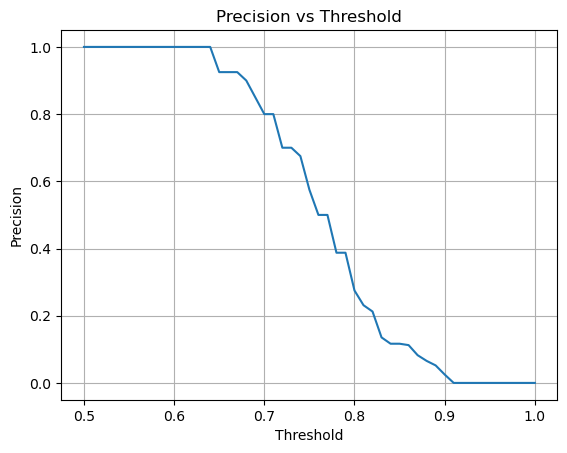

In [48]:
plt.plot(np.arange(0.5, 1.01, 0.01), results)
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)
plt.show()